In [392]:
#!g1.1

import time

import matplotlib.pyplot as plt

import torch
from torch import nn
import torchvision as tv
from torchsummary import summary

In [393]:
#!g1.1
# Используем Fasion EMNIST https://www.westernsydney.edu.au/icns/resources/reproducible_research3/publication_support_materials2/emnist

BATCH_SIZE = 256

def get_iters(image_size):
    transforms = tv.transforms.Compose([
        # Все предобученные сети обучались на трех каналах
        tv.transforms.Grayscale(3),
        tv.transforms.Resize((image_size, image_size)),
        tv.transforms.ToTensor()
    ])
    train_dataset = tv.datasets.EMNIST('.', train=True, split='letters', transform=transforms, download=True)
    test_dataset = tv.datasets.EMNIST('.', train=False, split='letters', transform=transforms, download=True)
    train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
    test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)
    return train_iter, test_iter

In [394]:
#!g1.1
# Поглядим на классы
train_dataset = tv.datasets.EMNIST('.', train=True, split='letters', transform=transforms, download=True)
LABELS = train_dataset.classes;
print('Class samples:', LABELS[0:10])
print('Number of classes:', len(LABELS))

Class samples: ['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i']
Number of classes: 27


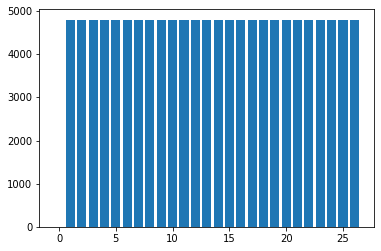

In [395]:
#!g1.1
# Проверим сбалансированность классов
class_counts = torch.bincount(train_dataset.targets)
plt.bar(range(len(class_counts)), class_counts)
plt.show()

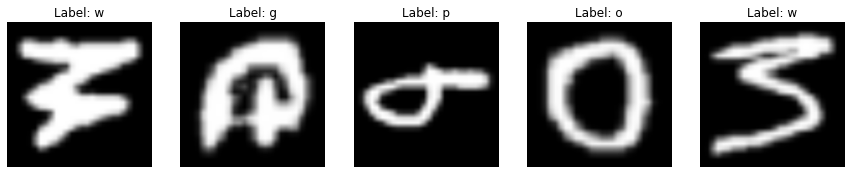

In [396]:
#!g1.1
# Поглядим на примеры с лейблами из датасета
fig, axs = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    img, label = train_dataset[i]
    axs[i].imshow(img[0].squeeze(), cmap='gray')
    axs[i].set_title(f'Label: {LABELS[label]}')
    axs[i].axis('off')
plt.show()

In [397]:
#!g1.1
# Загружаем в память нужные модели c натренированными весами для сверточных слоев

model_resnet18 = tv.models.resnet18(weights=tv.models.ResNet18_Weights.DEFAULT)
model_vgg16 = tv.models.vgg16(weights=tv.models.VGG16_Weights.DEFAULT)
model_inception = tv.models.inception_v3(weights=tv.models.Inception_V3_Weights.DEFAULT)
model_densenet = tv.models.densenet161(weights=tv.models.DenseNet161_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /tmp/xdg_cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 50.6MB/s]
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /tmp/xdg_cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 70.3MB/s]
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /tmp/xdg_cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:02<00:00, 38.8MB/s] 
Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /tmp/xdg_cache/torch/hub/checkpoints/densenet161-8d451a50.pth
100%|██████████| 110M/110M [00:03<00:00, 33.6MB/s]


In [398]:
#!g1.1
# Задаем классификаторы для нашей задачи

classifier_resnet18 = nn.Linear(in_features=512, out_features=len(LABELS))
classifier_vgg16 = nn.Sequential(
    nn.Linear(in_features=25088, out_features=4096),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(in_features=4096, out_features=4096),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(in_features=4096, out_features=27)
)
classifier_inception = nn.Linear(in_features=2048, out_features=len(LABELS))
classifier_densenet = nn.Linear(in_features=2208, out_features=len(LABELS))

In [399]:
#!g1.1
# Объявляем функции для посчета ошибки и обучения модели

def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0, 0
    net.eval()
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        n += y.shape[0]
    return acc_sum.item() / n

def train(net, train_iter, test_iter, trainer, num_epochs):
    net.to(device)
    train_accuracy = []
    loss = nn.CrossEntropyLoss(reduction='sum')
    net.train()
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        
        for i, (X, y) in enumerate(train_iter):
            X, y = X.to(device), y.to(device)
            trainer.zero_grad()
            # Iception-блок имеет специфичный формат выходного слоя
            y_hat = net(X)
            if y_hat.__class__.__name__ == 'InceptionOutputs':
                y_hat, aux_output = y_hat
            else:
                y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]

            if i % 100 == 0:
              print(f"Step {i}. time since epoch: {time.time() -  start:.3f}. " 
                    f"Train acc: {train_acc_sum / n:.3f}. Train Loss: {train_l_sum / n:.3f}")
              train_accuracy.append(train_acc_sum / n)
        test_acc = evaluate_accuracy(test_iter, net.to(device))
        print('-' * 20)
        print(f'epoch {epoch + 1}, loss {train_l_sum / n:.4f}, train acc {train_acc_sum / n:.3f}'
              f', test acc {test_acc:.3f}, time {time.time() - start:.1f} sec')
    return train_accuracy

In [400]:
#!g1.1
# Объявляем функцию для обучения конкретной модели

results = []
NUM_EPOCHS = 10

def train_model(model, classifier, image_size):
    # Получаем итераторы с изображениями нужного размера (модели предобучены на разных разрешениях)
    train_iter, test_iter = get_iters(image_size)
    
    # Убираем требование градиента:
    for param in model.parameters():
        param.requires_grad = False
    
    # Задачем свой слой для текущего числа лейблов
    classifier_layer = 'fc'
    if hasattr(model, 'classifier'):
        classifier_layer = 'classifier'
    setattr(model, classifier_layer, classifier)

    params_to_update = [(name, param) for name, param in model.named_parameters() if param.requires_grad == True]
    print("Params to update:", [name for name, param in params_to_update])
    
    trainer = torch.optim.Adam([param for name, param in params_to_update], lr=0.01)
    train_accuracy = train(model, train_iter, test_iter, trainer, NUM_EPOCHS)
    results.append({'name': model.__class__.__name__, 'accuracy': train_accuracy})

In [401]:
#!g1.1
# Проверяем готовность gpu

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [402]:
#!g1.1
# Обучаем модели

train_model(model_resnet18, classifier_resnet18, 244)
train_model(model_vgg16, classifier_vgg16, 244)
train_model(model_inception, classifier_inception, 299)
train_model(model_densenet, classifier_densenet, 244)

Params to update: ['fc.weight', 'fc.bias']
Step 0. time since epoch: 12.136. Train acc: 0.035. Train Loss: 3.476
Step 100. time since epoch: 70.703. Train acc: 0.616. Train Loss: 1.427
Step 200. time since epoch: 129.499. Train acc: 0.696. Train Loss: 1.077
Step 300. time since epoch: 188.270. Train acc: 0.734. Train Loss: 0.924
Step 400. time since epoch: 247.255. Train acc: 0.752. Train Loss: 0.844
--------------------
epoch 1, loss 0.7935, train acc 0.765, test acc 0.822, time 329.4 sec
Step 0. time since epoch: 0.579. Train acc: 0.816. Train Loss: 0.605
Step 100. time since epoch: 57.054. Train acc: 0.832. Train Loss: 0.540
Step 200. time since epoch: 114.117. Train acc: 0.833. Train Loss: 0.532
Step 300. time since epoch: 170.691. Train acc: 0.836. Train Loss: 0.524
Step 400. time since epoch: 227.133. Train acc: 0.835. Train Loss: 0.524
--------------------
epoch 2, loss 0.5211, train acc 0.836, test acc 0.823, time 307.7 sec
Step 0. time since epoch: 0.558. Train acc: 0.836. Tra

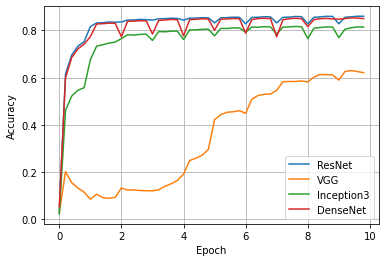

In [403]:
#!g1.1
plt.figure()
for model in results:
    plt.plot([iteration / 5 for iteration in range(len(model["accuracy"]))], model["accuracy"], label=model["name"])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()


1. Inception3: Модель выходит на уровень ~0.8 к 4 эпохе и достигает максимальной точности примерно на 6 эпохе обучения. По истечению 10 эпох ее точность ниже, чем у остальных моделей. Наиболее вероятно, что для 27-классовой классификации количество признаков избыточно и в этом случае недостаточно одного слоя в полносвязном классификаторе. Было бы полезно добавить еще 1-2 скрытых полносвязных слоя. 

2. DenseNet: Точность модели быстро растет и достигает 0.85 после 3 эпох обучения. После этого точность продолжает расти, но с меньшей скоростью. Ее точность примерно равно ResNet, но требует бОльших вычислительных ресурсов. И, опять же, было бы полезно попробовать добавить промежуточных слоев в голову-классификатор.

3. ResNet: Кривая обучения практически идентична DenseNet и с теми же характеристиками. Однако модель гораздо "легче" и обучается в ~2.5 раза быстрее DenseNet. Итоговая точность 0.86.

4. VGG: Точность модели VGG значительно ниже, чем у других моделей на первых эпохах, однако в итоге может достигать при текущих настройках 0.87. Для VGG нужен более долгий процесс обучения, чтобы надежно получить высокую точность (в данном прогоне ее точность не поднялась сильно выше 0.6 по истечению 10 эпох). Это следствие большого количества параметров и сложности классификатора.

Итого, решение для конкретного датасета выбираем исходя из требуемой точности и количества ресурсов. Для рассматриваемого датасета из предложенного набора моделей, кажется, вполне хватает ResNet, если ограничиваемся 10 эпохами.


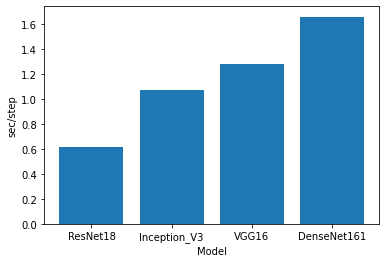

In [404]:
#!g1.1
# Визаулизируем длительность процесса обучения моделей
plt.bar(['ResNet18', 'Inception_V3', 'VGG16', 'DenseNet161'], [0.62, 1.07,  1.28, 1.66])
plt.xlabel('Model')
plt.ylabel('sec/step')
plt.show()

In [ ]:
#!g1.1
